In [2]:
!pip install plotly
!pip install kneed
%pip install prophet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import json

In [38]:
def determine_anomaly_weight(df, row):
  if row['is_anomaly'] == 1:
    #print(f"Processing anomaly at {df['ds']}")
    subset = df[(df['ds'] >= row['ds'] - pd.Timedelta(hours=8)) & (df['ds'] <= row['ds'] + pd.Timedelta(hours=8))]
    #print(len(subset))
    if not subset.empty:
      #print("Subset is not empty")
      result = min(abs(subset['yhat_upper'] - row['y']).min(),
                      abs(subset['yhat_lower'] - row['y']).min())
    else:
        #print("Subset is empty")
        result = abs(row['yhat_upper'] - row['y'])
  else:
    result = 0
  return result

In [39]:
def prophet_model(df, dimension):

  subset = df[['time', dimension]].reset_index()
  subset = subset.assign(y=subset[dimension]).assign(ds=subset['time']).drop(columns=['time', dimension])

  #Initializing and fitting the prophet model
  m = Prophet()
  m.fit(subset)

  #Creating prophet predictions on historical data
  future = m.make_future_dataframe(periods=0)
  forecast = m.predict(future)

  #Assigning forecast dataframe the initial y values (no. of events using this device), is_anomaly (if it is an anomaly or not), and anomaly_weight (how far it is from either yhat_upper or lower)
  forecast['y'] = subset['y']
  forecast['is_anomaly'] = forecast.apply(lambda row: 1 if not (row['yhat_lower'] <= row['y'] <= row['yhat_upper']) else 0, axis=1)
  forecast['diff'] = abs(forecast['yhat'] - forecast['y'])
  forecast['percent_diff'] = (abs(forecast['yhat'] - forecast['y'])/forecast['y'].where(forecast['y'] != 0))
  forecast['anomaly_weight'] = forecast.apply(lambda row: determine_anomaly_weight(forecast, row), axis=1)

  #Plotting forecast, anomaly, and forecast components
  plt.figure(figsize=(30, 20))  # Set the figure size to a larger size (width=12, height=8)
  fig1 = m.plot(forecast)
  anomalies = forecast[forecast['is_anomaly'] == 1]
  plt.scatter(anomalies['ds'], anomalies['y'], color='red', s=20, label='Anomalies')
  plt.title(f"{dimension}")

  return forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'y', 'is_anomaly', "diff","percent_diff"]]

In [40]:
visitors_by_geography = pd.read_csv('visitors_by_geography.csv')
visitors_by_device = pd.read_csv('visitors_by_device.csv')
buyers_by_geography = pd.read_csv('buyers_by_geography.csv')
buyers_by_device = pd.read_csv('buyers_by_device.csv')
orders_by_geography = pd.read_csv('orders_by_geography.csv')
orders_by_device = pd.read_csv('orders_by_device.csv')

visitors_by_geography['time'] = pd.to_datetime(visitors_by_geography['time'], format='mixed')
visitors_by_geography['time'] = visitors_by_geography['time'].dt.tz_localize(None)
visitors_by_geography["time"] = visitors_by_geography["time"].dt.floor("h")

visitors_by_device['time'] = pd.to_datetime(visitors_by_device['time'], format='mixed')
visitors_by_device['time'] = visitors_by_device['time'].dt.tz_localize(None)
visitors_by_device["time"] = visitors_by_device["time"].dt.floor("h")

orders_by_geography['time'] = pd.to_datetime(orders_by_geography['time'], format='mixed')
orders_by_geography['time'] = orders_by_geography['time'].dt.tz_localize(None)
orders_by_geography["time"] = orders_by_geography["time"].dt.floor("h")

orders_by_device['time'] = pd.to_datetime(orders_by_device['time'], format='mixed')
orders_by_device['time'] = orders_by_device['time'].dt.tz_localize(None)
orders_by_device["time"] = orders_by_device["time"].dt.floor("h")

buyers_by_geography['time'] = pd.to_datetime(buyers_by_geography['time'], format='mixed')
buyers_by_geography['time'] = buyers_by_geography['time'].dt.tz_localize(None)
buyers_by_geography["time"] = buyers_by_geography["time"].dt.floor("h")

buyers_by_device['time'] = pd.to_datetime(buyers_by_device['time'], format='mixed')
buyers_by_device['time'] = buyers_by_device['time'].dt.tz_localize(None)
buyers_by_device["time"] = buyers_by_device["time"].dt.floor("h")

In [41]:
visitors_by_device

,time_hour,time,macOS,Linux,Other,iOS,Windows,Android,Total
0,1,2025-01-22 01:00:00,37,2,15,602,17,100,773
1,2,2025-01-22 02:00:00,46,2,26,449,14,58,595
2,3,2025-01-22 03:00:00,22,0,18,422,18,72,552
3,4,2025-01-22 04:00:00,28,0,14,322,16,58,438
4,5,2025-01-22 05:00:00,29,0,27,357,15,82,510
...,...,...,...,...,...,...,...,...,...
1410,19,2025-03-21 19:00:00,93,2,43,2233,52,500,2923
1411,20,2025-03-21 20:00:00,100,4,34,2733,68,595,3534
1412,21,2025-03-21 21:00:00,109,6,37,2537,53,590,3332
1413,22,2025-03-21 22:00:00,61,0,34,2235,46,459,2835


# Top Level Prophet Models

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc7o8go9m/b0ejpxnc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc7o8go9m/kjhcwya5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22772', 'data', 'file=/tmp/tmpc7o8go9m/b0ejpxnc.json', 'init=/tmp/tmpc7o8go9m/kjhcwya5.json', 'output', 'file=/tmp/tmpc7o8go9m/prophet_modelbqzlrcrz/prophet_model-20250420202025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat_lower,yhat_upper,yhat,y,is_anomaly,diff,percent_diff
0,2025-01-22 01:00:00,-458.655901,1441.832735,506.492939,773,0,266.507061,0.344770
1,2025-01-22 02:00:00,-597.107125,1415.502765,382.238842,595,0,212.761158,0.357582
2,2025-01-22 03:00:00,-683.013155,1376.040054,363.186434,552,0,188.813566,0.342054
3,2025-01-22 04:00:00,-662.736119,1327.146346,343.233452,438,0,94.766548,0.216362
4,2025-01-22 05:00:00,-498.705370,1534.062706,435.628588,510,0,74.371412,0.145826
...,...,...,...,...,...,...,...,...
1410,2025-03-21 19:00:00,2312.522705,4408.285385,3348.254053,2923,0,425.254053,0.145485
1411,2025-03-21 20:00:00,2791.459517,4737.287205,3741.168604,3534,0,207.168604,0.058622
1412,2025-03-21 21:00:00,2468.840935,4561.135790,3496.968093,3332,0,164.968093,0.049510
1413,2025-03-21 22:00:00,1578.382534,3585.935420,2605.803760,2835,0,229.196240,0.080845


<Figure size 3000x2000 with 0 Axes>

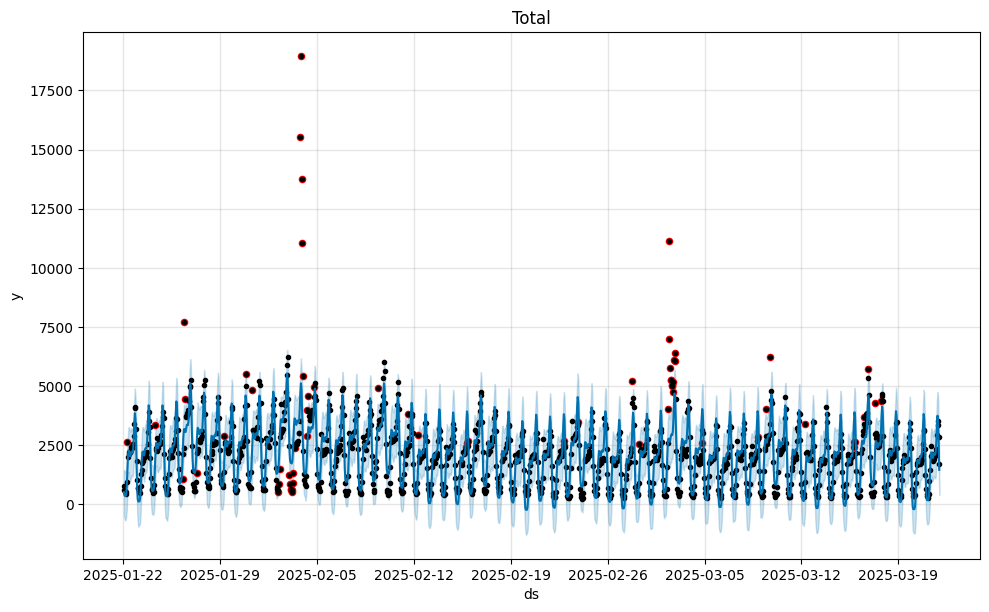

In [42]:
visitors_top_level = prophet_model(visitors_by_geography, 'Total')
visitors_top_level

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc7o8go9m/5g2semcg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc7o8go9m/a34nxcp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60921', 'data', 'file=/tmp/tmpc7o8go9m/5g2semcg.json', 'init=/tmp/tmpc7o8go9m/a34nxcp8.json', 'output', 'file=/tmp/tmpc7o8go9m/prophet_model5a89gdy3/prophet_model-20250420202028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat_lower,yhat_upper,yhat,y,is_anomaly,diff,percent_diff
0,2025-01-22 01:00:00,-40.507795,11.677661,-14.242673,5,0,19.242673,3.848535
1,2025-01-22 02:00:00,-43.110021,12.157497,-14.737189,8,0,22.737189,2.842149
2,2025-01-22 03:00:00,-38.819178,16.153175,-13.157859,5,0,18.157859,3.631572
3,2025-01-22 04:00:00,-43.404191,12.234538,-14.606078,4,0,18.606078,4.651519
4,2025-01-22 05:00:00,-40.812771,12.875862,-14.437433,3,0,17.437433,5.812478
...,...,...,...,...,...,...,...,...
1409,2025-03-21 19:00:00,106.133359,160.874948,133.298372,123,0,10.298372,0.083727
1410,2025-03-21 20:00:00,116.259497,170.759723,143.369183,121,0,22.369183,0.184869
1411,2025-03-21 21:00:00,105.547693,159.348923,132.190170,127,0,5.190170,0.040867
1412,2025-03-21 22:00:00,72.168399,126.609815,99.645561,84,0,15.645561,0.186257


<Figure size 3000x2000 with 0 Axes>

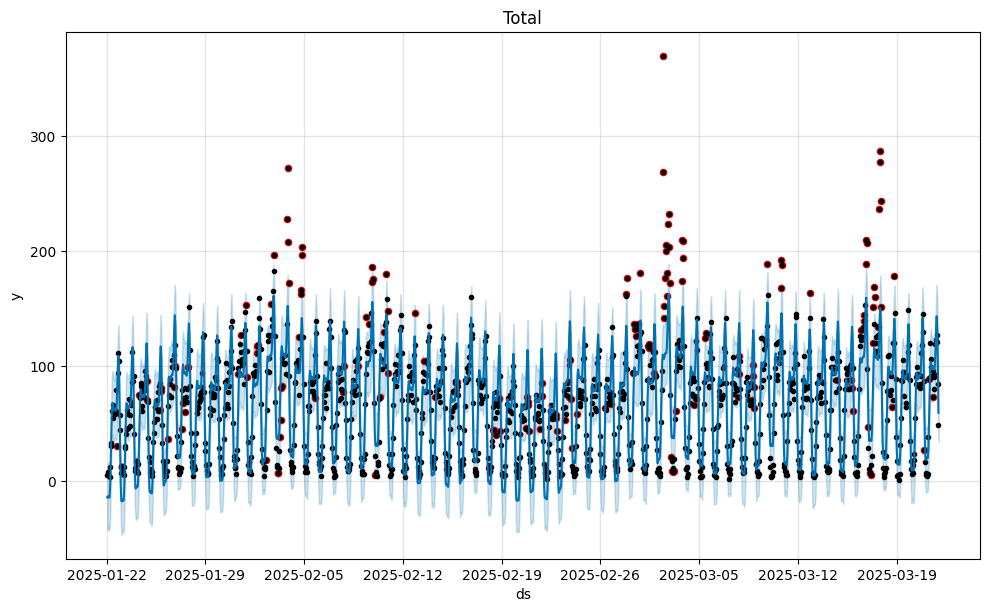

In [43]:
orders_top_level = prophet_model(orders_by_geography, 'Total')
orders_top_level

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc7o8go9m/dh9c1s2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc7o8go9m/vzb8kdxw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99331', 'data', 'file=/tmp/tmpc7o8go9m/dh9c1s2g.json', 'init=/tmp/tmpc7o8go9m/vzb8kdxw.json', 'output', 'file=/tmp/tmpc7o8go9m/prophet_modelf7tdby62/prophet_model-20250420202029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat_lower,yhat_upper,yhat,y,is_anomaly,diff,percent_diff
0,2025-01-22 01:00:00,-40.507795,11.677661,-14.242673,5,0,19.242673,3.848535
1,2025-01-22 02:00:00,-43.110021,12.157497,-14.737189,8,0,22.737189,2.842149
2,2025-01-22 03:00:00,-38.819178,16.153175,-13.157859,5,0,18.157859,3.631572
3,2025-01-22 04:00:00,-43.404191,12.234538,-14.606078,4,0,18.606078,4.651519
4,2025-01-22 05:00:00,-40.812771,12.875862,-14.437433,3,0,17.437433,5.812478
...,...,...,...,...,...,...,...,...
1409,2025-03-21 19:00:00,106.133359,160.874948,133.298372,123,0,10.298372,0.083727
1410,2025-03-21 20:00:00,116.259497,170.759723,143.369183,121,0,22.369183,0.184869
1411,2025-03-21 21:00:00,105.547693,159.348923,132.190170,127,0,5.190170,0.040867
1412,2025-03-21 22:00:00,72.168399,126.609815,99.645561,84,0,15.645561,0.186257


<Figure size 3000x2000 with 0 Axes>

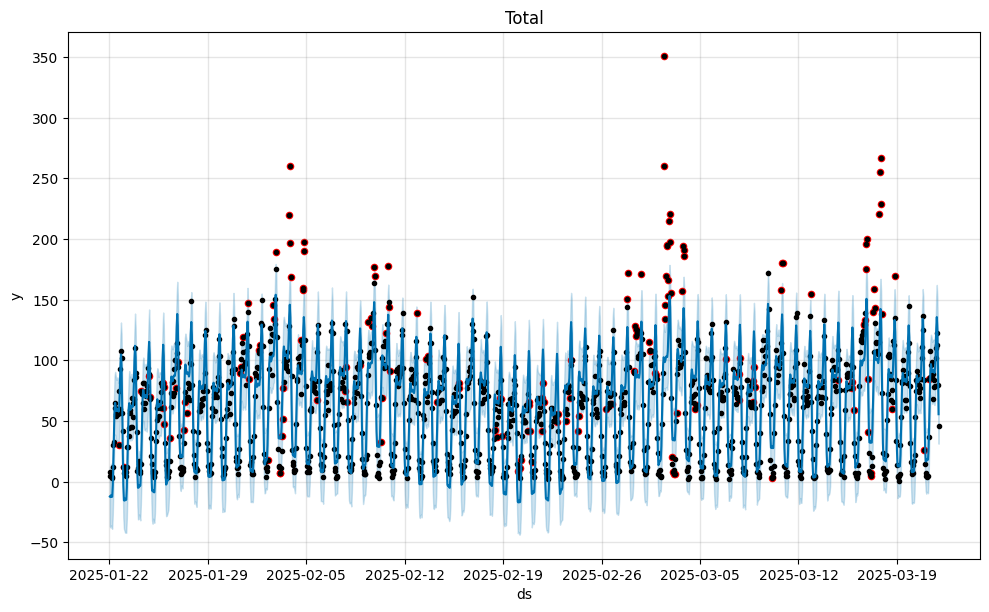

In [44]:
buyers_top_level = prophet_model(buyers_by_geography, 'Total')
orders_top_level

# Anomaly Contributions

In [45]:
def anomaly_contribution(site_visits_top_level,site_visits_bottom_level, dimension_list):
  site_visits_top_level_new = site_visits_top_level.copy()
  site_visits_top_level_new["pred added"] = 0
  site_visits_top_level_new["diff added"] = 0
  site_visits_top_level_new["diff sign added"] = 0

  for dimension in dimension_list:
    data_curr = prophet_model(site_visits_bottom_level, dimension)
    site_visits_top_level_new["pred "+dimension] = data_curr['yhat']
    site_visits_top_level_new["diff "+dimension] = data_curr['diff']
    site_visits_top_level_new['percent_diff ' + dimension] = data_curr['percent_diff']


    #Aggregated anomaly weights by dimension for verification with total anomaly weight found at top level
    site_visits_top_level_new["pred added"] += site_visits_top_level_new["pred "+dimension]
    site_visits_top_level_new["diff added"] += site_visits_top_level_new["diff "+dimension]


  for dimension in dimension_list:
    site_visits_top_level_new["perc diff "+dimension] = site_visits_top_level_new["diff "+dimension]/site_visits_top_level_new["diff added"]
    print(dimension + " added!")
  return site_visits_top_level_new

In [46]:
def anomaly_percents(site_visits_top_levell,site_visits_bottom_level, geo_list):
  site_visits_top_level_new = site_visits_top_levell.copy()
  for geo in geo_list:
    data_curr = prophet_model(site_visits_bottom_level, geo)
    # site_visits_top_level_new["diff "+geo] = data_curr['diff']
    site_visits_top_level_new["percent_diff "+geo] = data_curr['percent_diff']
  return site_visits_top_level_new

In [47]:
geo_list = ["Global", "US"]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc7o8go9m/4uwkxd8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc7o8go9m/d4ypxxz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49600', 'data', 'file=/tmp/tmpc7o8go9m/4uwkxd8e.json', 'init=/tmp/tmpc7o8go9m/d4ypxxz0.json', 'output', 'file=/tmp/tmpc7o8go9m/prophet_modelre24mouo/prophet_model-20250420202648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

,ds,yhat_lower,yhat_upper,yhat,y,is_anomaly,diff,percent_diff,percent_diff Global,percent_diff US
6,2025-01-22 07:00:00,370.899551,2434.805598,1392.667702,2630,1,1237.332298,0.470469,0.520780,0.018035
54,2025-01-24 07:00:00,577.378534,2661.699508,1676.315840,3328,1,1651.684160,0.496299,0.532596,0.350825
102,2025-01-26 07:00:00,1139.235050,3229.845827,2163.254175,1077,1,1086.254175,1.008593,1.043217,0.833152
105,2025-01-26 10:00:00,2115.629265,4222.395608,3179.310566,7715,1,4535.689434,0.587905,0.608181,2.093055
106,2025-01-26 11:00:00,2140.893022,4083.857268,3065.285446,4461,1,1395.714554,0.312870,0.345626,1.955231


<Figure size 3000x2000 with 0 Axes>

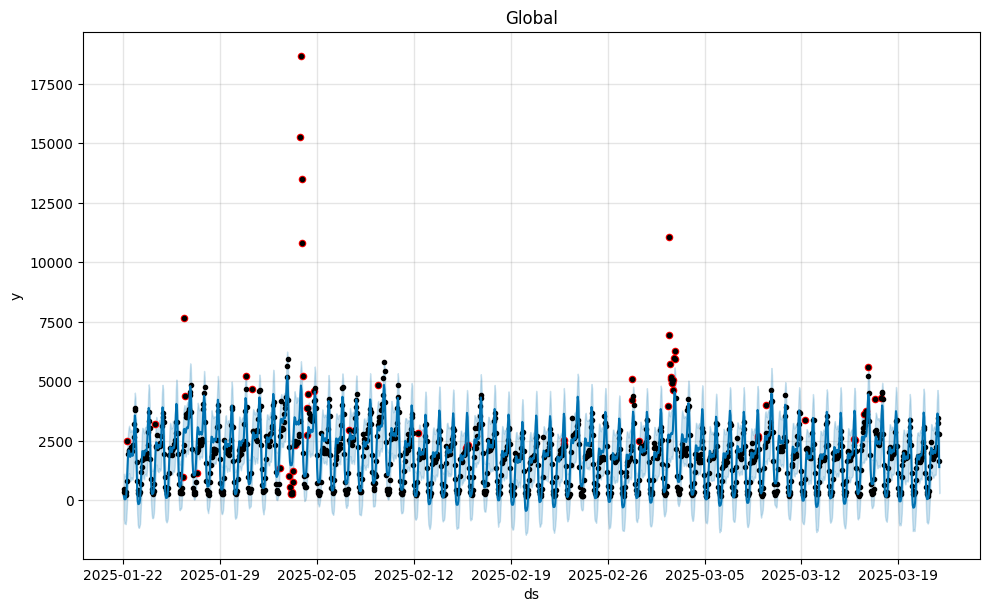

<Figure size 3000x2000 with 0 Axes>

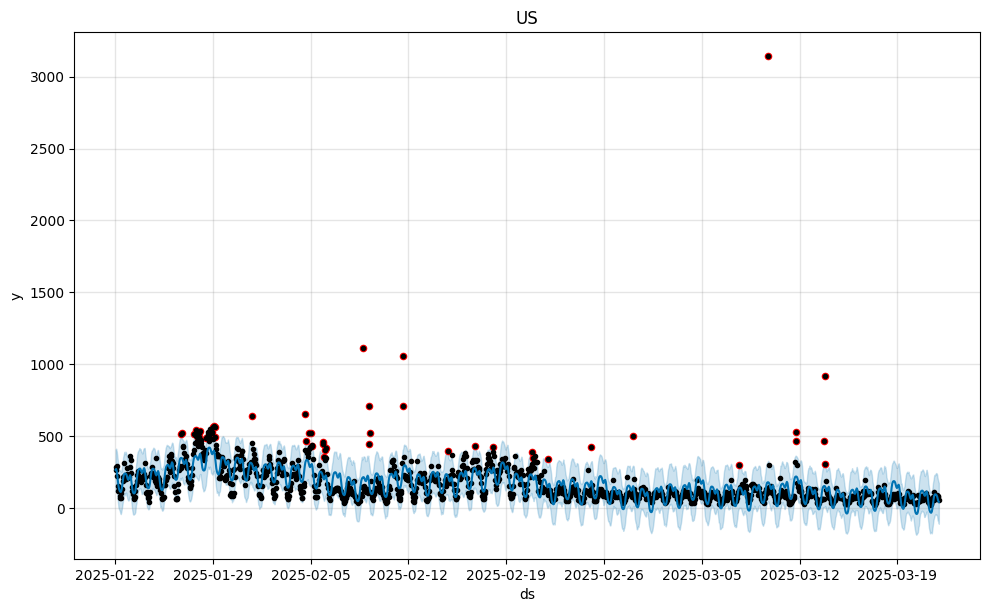

In [50]:
visitors_contributions = anomaly_percents(visitors_top_level,visitors_by_geography, geo_list)
visitors_top_level_new_anoms = visitors_contributions[visitors_contributions["is_anomaly"] == 1]
visitors_top_level_new_anoms.head()

In [ ]:
orders_contributions = anomaly_percents(orders_top_level,visitors_by_geography, geo_list)
visitors_top_level_new_anoms = orders_contributions[orders_contributions["is_anomaly"] == 1]
visitors_top_level_new_anoms.head()